# (2, 2)-shor-encoded 6-ring graph construction

This notebook shows how the Hadamard gates applied on four vertices in figure 3c of [arXiv:2412.08611v2](https://arxiv.org/pdf/2412.08611) [quant-ph] work.

In particular it clearly shows a point kept under silence in the paper: each Hadamard gate is equivalent to a sequence 3 local-complementation operations. The LC operations are not explicitely performed, it suffices to apply the 4 Hadamard gates to obtain the correct graph.

In [218]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Conversions between different representations of graphs

#### Pauli strings <-> X, Z tableau

In [219]:
def pauli_string_to_tableau_row(p):
    p = p.replace(" ", "").strip().upper()
    x, z = [], []
    for c in p:
        index = list("IZXY").index(c)
        x.append(index // 2)
        z.append(index & 1)
    return np.array(x + z, dtype=int)

def tableau_row_to_pauli_string(row):
    n = len(row) // 2
    return "".join("IZXY"[2 * row[i] + row[i+n]] for i in range(n))

def pp_stabilizers(l):
    # Just a pretty printing function...
    for i, k in enumerate(l):
        print(f"K_{i}\t| { k }")

#### NX Graph <-> stabilizers

In [220]:
def graph_to_stabilizers(G):
    nodes = list(G.nodes())
    stabs = []
    for i, u in enumerate(nodes):
        stabs.append("".join("X" if j == i else ("Z" if G.has_edge(u, v) else "I") for j, v in enumerate(nodes)))
    return stabs

def stabilizers_to_graph(stabilizers):
    n = len(stabilizers)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        assert stabilizers[i][i] == "X"
        for j in range(i + 1, n):
            if stabilizers[i][j] == "Z":
                assert stabilizers[j][i] == "Z"
                G.add_edge(i, j)
    return G

## We define the "skeleton" graph here (Figure 3 c)

In [221]:
edges = [
    # Central ring
    (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0),
    # Outer ring
    (0, 6),
    (0, 7), (7, 2),
    (2, 8),
    (3, 9),
    (3, 10), (10, 5),
    (5, 11)
]

G = nx.Graph(edges)

# Manually set positions for the vertices
points = np.exp(1j * 2 * np.pi * (np.arange(6) + 0.5) / 6)
scales = [1, 1.4]
rings_12 = [(-s * p.real, s * p.imag) for s in scales for p in points]

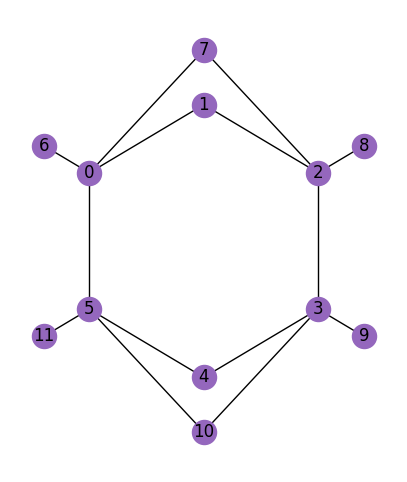

In [294]:
def draw_graph(G, positions, size=(5, 6)):
    fig, axs = plt.subplots(figsize=size)
    n = len(positions)
    nodes = list(range(n))
    node_labels = dict(zip(nodes, map(str, nodes)))
    nx.draw(G, pos=positions, labels=node_labels, ax=axs, node_color="tab:purple")

draw_graph(G, rings_12)

In [295]:
# Check that we get the correct list of stabilizers
stabs = graph_to_stabilizers(G)
pp_stabilizers(stabs)

K_0	| XZIIIZZZIIII
K_1	| ZXZIIIIIIIII
K_2	| IZXZIIIZZIII
K_3	| IIZXZIIIIZZI
K_4	| IIIZXZIIIIII
K_5	| ZIIIZXIIIIZZ
K_6	| ZIIIIIXIIIII
K_7	| ZIZIIIIXIIII
K_8	| IIZIIIIIXIII
K_9	| IIIZIIIIIXII
K_10	| IIIZIZIIIIXI
K_11	| IIIIIZIIIIIX


## Apply Hadamard on the 4 qubits

In [296]:
def hadamard(pauli_strings, indices):
    H = {"I": "I", "X": "Z", "Z": "X", "Y": "Y"}  # ignore signs!
    for pauli_string in pauli_strings:
        yield "".join([H[p] if i in indices else p for i, p in enumerate(pauli_string)])

In [297]:
new_strings = list(hadamard(stabs, [0, 2, 3, 5]))
new_tableau = np.array([pauli_string_to_row(ps) for ps in new_strings])

print(new_tableau)
print()
pp_stabilizers(new_strings)

[[0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0]
 [0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]

K_0	| ZZIIIXZZIIII
K_1	| XXXIIIIIIIII
K_2	| IZZXIIIZZIII
K_3	| IIXZZIIIIZZI
K_4	| IIIXXXIIIIII
K_5	| XIIIZZIIIIZZ
K_6	| XIIIIIXIIIII
K_7	| XIXIIIIXIIII
K_8	| IIXIIIIIXIII
K_9	| IIIXIIIIIXII
K_10	| IIIXIXIIIIXI
K_11	| IIIIIXIIIIIX


## Normalize a tableau to a proper graph state

In [298]:
def to_graph_state_normal_form(M):
    M = M.copy()
    n = M.shape[1] // 2
    row = 0
    for col in range(n):
        pivot = np.where(M[row:, col] == 1)[0]
        if pivot.size > 0:
            p = pivot[0] + row
            M[[row, p]] = M[[p, row]]

            # XOR all rows where the current column is 1, except the pivot row
            targets = (M[:, col] == 1)
            targets[row] = False 
            M[targets] ^= M[row]
            row += 1
    return M

proper_graph_state_tableau = to_graph_state_normal_form(new_tableau)

In [299]:
proper_graph_state_stabs = [row_to_pauli_string(row) for row in proper_graph_state_tableau]
pp_stabilizers(proper_graph_state_stabs)

K_0	| XIIIZZIIIIZZ
K_1	| IXIZIZIIIZIZ
K_2	| IIXZZIIIIZZI
K_3	| IZZXIIIZZIII
K_4	| ZIZIXIZIZIII
K_5	| ZZIIIXZZIIII
K_6	| IIIIZZXIIIZZ
K_7	| IIIZIZIXIZIZ
K_8	| IIIZZIIIXZZI
K_9	| IZZIIIIZZXII
K_10	| ZIZIIIZIZIXI
K_11	| ZZIIIIZZIIIX


In [300]:
new_G = stabilizers_to_graph(proper_graph_state_stabs)

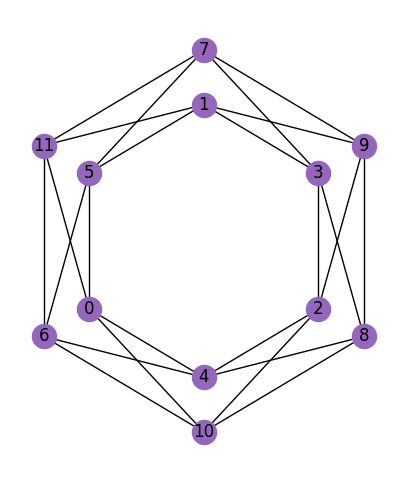

In [301]:
# The 4 Hadamard operations will "twist" the graph
permutation = [5, 1, 3, 2, 4, 0, 11, 7, 9, 8, 10, 6]
rings_12_permuted = [rings_12[permutation[i]] for i in range(12)]
draw_graph(new_G, rings_12_permuted)

## H on a vertex <=> LC on vertex, neighbor, vertex

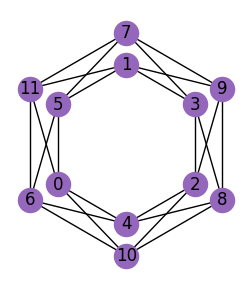

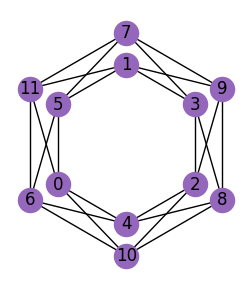

In [311]:
def local_complementation(G, v):
    G = G.copy()
    neighbors = list(G.neighbors(v))
    neighborhood = G.subgraph(neighbors)
    new_edges = nx.complement(neighborhood).edges()
    G.remove_edges_from(neighborhood.edges())
    G.add_edges_from(new_edges)
    return G

def local_complementation_multiple(G, vertices):
    for v in vertices:
        G = local_complementation(G, v)
    return G

def hadamard_with_3xLC(G, vertices):
    for v in vertices:
        a_neighbor = list(G.neighbors(v))[0]
        G = local_complementation(G, v)
        G = local_complementation(G, a_neighbor)
        G = local_complementation(G, v)
    return G

draw_graph(hadamard_with_3xLC(G, [0, 2, 3, 5]), rings_12_permuted, size=(3, 3.5))
draw_graph(local_complementation_multiple(G, [0, 1, 0, 2, 0, 2, 3, 1, 3, 5, 0, 5]), rings_12_permuted, size=(3, 3.5))

## Simpler chain with 6 LC operations

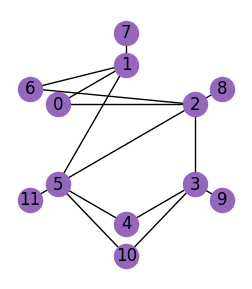

In [320]:
draw_graph(local_complementation_multiple(G, [0, 1, 0]), rings_12, size=(3, 3.5))